<a href="https://colab.research.google.com/github/param1707/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/blob/main/Basic%20CNN%20Autoencoder/BasicCNNAutoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Basic Convolutional Neural Network AutoEncoder notebook**

In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import scipy.io.wavfile as wav
#from sound import sound

In [64]:
def signal2pytorch(x):
   #Function to convert a signal vector x, like a mono audio signal, into a 3-d Tensor that conv1d of Pytorch expects,
   #Argument x: a 1-d signal as numpy array
   #input x[batch,sample]
   #output: 3-d Tensor X for conv1d input.
   #for conv1d Input: (N,Cin,Lin), Cin: numer of input channels (e.g. for stereo), Lin: length of signal, N: number of Batches (signals) 
   X = np.expand_dims(x, axis=0)  #add channels dimension (here only 1 channel)
   if len(x.shape)==1: #mono:
      X = np.expand_dims(X, axis=0)  #add batch dimension (here only 1 batch)
   X=torch.from_numpy(X)
   X=X.type(torch.Tensor)
   X=X.permute(1,0,2)  #make batch dimension first
   return X

In [65]:
class Convautoenc(nn.Module):
   def __init__(self):
      super(Convautoenc, self).__init__()
      #Analysis Filterbank with downsampling of N=1024, filter length of 2N, but only N/2 outputs:
      self.conv1=nn.Conv1d(in_channels=1, out_channels=32, kernel_size=2048, stride=1024, padding=1023, bias=True) #Padding for 'same' filters (kernel_size/2-1)

      #Synthesis filter bank:
      self.synconv1=nn.ConvTranspose1d(in_channels=32, out_channels=1, kernel_size=2048, stride=1024, padding=1023, bias=True)

   def encoder(self, x):
      #Analysis:
      x = self.conv1(x)
      y = torch.tanh(x)
      return y
      
   def decoder(self, y):
      #Synthesis:
      xrek= self.synconv1(y)
      return xrek
      
   def forward(self, x):
      y=self.encoder(x)
      #y=torch.round(y/0.125)*0.125
      xrek=self.decoder(y)
      return xrek

In [69]:
!wget https://raw.githubusercontent.com/param1707/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/main/Track16.wav
print('Track16.wav loaded')

--2020-10-25 16:52:06--  https://raw.githubusercontent.com/param1707/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/main/Track16.wav
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1790336 (1.7M) [audio/wav]
Saving to: ‘Track16.wav.4’

Track16.wav.4       100%[===================>]   1.71M  --.-KB/s    in 0.1s    

2020-10-25 16:52:06 (12.1 MB/s) - ‘Track16.wav.4’ saved [1790336/1790336]

Track16.wav loaded


In [76]:
batch=2 #number of audio files in the batch
filename = 'Track16.wav'
fs, audio = wav.read(filename)
audio0=audio[:,0] #make it mono left channel
audio1=audio[:,1] #make it mono right channel
#audio=audio*1.0/2**15 #normalize
audio0=audio0*1.0/np.max(np.abs(audio0)) #normalize
audio1=audio1*1.0/np.max(np.abs(audio1)) #normalize
print("audio0.shape=", audio0.shape)
#audiosh=audio[46750:58750] #shorten the signal for faster optimization,
#audiosh=audio[10000:60000] 

X=signal2pytorch(audio0) #Convert to pytorch format, batch is first dimension    

print("Generate Model:")
model = Convautoenc()

print("Def. loss function:")
loss_fn = nn.MSELoss()  #MSE
#loss_fn = nn.L1Loss()

Ypred=model(X)

outputlen=len(Ypred[0,0,:]) #length of the signal at the output of the network.
print("outputlen=", outputlen)

Y=X[:,:,:outputlen]  #the target signal with same length as model output

print("Input X.shape=", X.shape )
print("Target Y.shape=", Y.shape)
print("Target Y=", Y)

print("Y.type()=", Y.type())


learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Ypred=model(X)
#Ypred=Ypred.detach()
print("Ypred=", Ypred)

audio0.shape= (447573,)
Generate Model:
Def. loss function:
outputlen= 447490
Input X.shape= torch.Size([1, 1, 447573])
Target Y.shape= torch.Size([1, 1, 447490])
Target Y= tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -4.5912e-05,
           4.5912e-05, -4.5912e-05]]])
Y.type()= torch.FloatTensor
Ypred= tensor([[[0.0049, 0.0035, 0.0059,  ..., 0.0085, 0.0035, 0.0050]]],
       grad_fn=<SqueezeBackward1>)


In [84]:
losses = np.zeros(1999)
for epoch in range(2000):
          Ypred=model(X)
          losses[epoch - 1] = loss.item()
          loss=loss_fn(Ypred, Y)
          if epoch%10==0:
             print(epoch, loss.item())
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

0 0.0011529640760272741
10 0.0011485632276162505
20 0.001144219422712922
30 0.0011399250943213701
40 0.0011356845498085022
50 0.0011314955772832036
60 0.0011273582931607962
70 0.0011232702527195215
80 0.0011192308738827705
90 0.0011152449296787381
100 0.001111305202357471
110 0.0011074129724875093
120 0.0011035705683752894
130 0.001099772984161973
140 0.0010960226645693183
150 0.0010923187946900725
160 0.0010886610252782702
170 0.0010850478429347277
180 0.001081479829736054
190 0.0010779547737911344
200 0.0010744734900072217
210 0.0010710344649851322
220 0.0010676385136321187
230 0.001064283074811101
240 0.00106097012758255
250 0.0010576967615634203
260 0.0010544640244916081
270 0.0010512712178751826
280 0.0010481156641617417
290 0.0010449993424117565
300 0.0010419219033792615
310 0.0010388813680037856
320 0.0010358772706240416
330 0.001032909145578742
340 0.001029977691359818
350 0.00102707976475358
360 0.0010242178104817867
370 0.0010213896166533232
380 0.0010185936698690057
390 0.00

In [85]:
print(range(epoch))
print(losses)

range(0, 1999)
[0.00115296 0.00115252 0.00115208 ... 0.00079134 0.00079127 0.0007912 ]


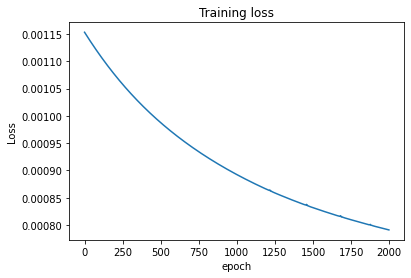

In [86]:
plt.figure(1)

plt.plot(range(epoch),losses)
plt.title('Training loss');
plt.xlabel('epoch'); plt.ylabel('Loss');
plt.show()